In [1]:
%pylab inline
import torch
import sys
sys.path.append('..')
sys.path.append('../..')
from data import load
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device = ', device)

Populating the interactive namespace from numpy and matplotlib
device =  cpu


In [2]:
# Let's load the dataset
train_data, train_label = load.get_dogs_and_cats_data(resize=(32,32))
valid_data, valid_label = load.get_dogs_and_cats_data(split='valid', resize=(32,32))
input_size = 32*32*3
to_image = load.to_image_transform()

train_data, train_label = train_data.to(device), train_label.to(device)
valid_data, valid_label = valid_data.to(device), valid_label.to(device)

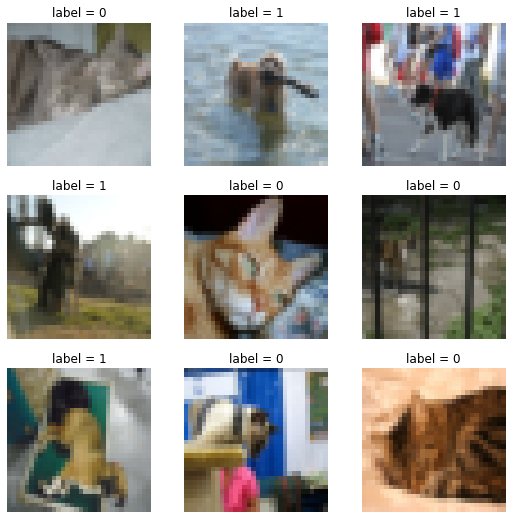

In [3]:
figure(figsize=(9,9))
for i, (data, label) in enumerate(zip(train_data[:9],train_label[:9])):
    subplot(3,3,i+1)
    imshow(to_image(data))
    title('label = %d' %label)
    axis('off')


In [4]:
class Network1(torch.nn.Module):
    def __init__(self, n_hidden=100):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, n_hidden)
        self.linear2 = torch.nn.Linear(n_hidden, 1)
        self.activation = torch.nn.ReLU()
    def forward(self, x):
        return self.linear2(self.activation(self.linear1(x.view(x.size(0),-1))))
    

In [5]:
net1 = Network1(100)
#view(-1) flatten, detach from tensor and convert to numpy
print(net1(train_data).view(-1).detach().numpy())

[-0.15780824 -0.21669203 -0.21489745 ...  0.00540022 -0.1213725
 -0.06409398]


In [6]:
#create a network takes input of arbitrary number of hidden layers
class Network2(torch.nn.Module):
    def __init__(self, *n_hidden):
        super().__init__()
        layer=[]
        in_size = input_size
        for h in n_hidden:
            layer.append(torch.nn.Linear(in_size, h))
            in_size = h
            layer.append(torch.nn.ReLU())
        #sequential to build network
        self.network = torch.nn.Sequential(*layer)
        #classification layer to produce one single output
        #in_size is already updated while iterating through n_hidden
        self.classifier = torch.nn.Linear(in_size, 1)
    def forward(self,x):
        return self.classifier(self.network(x.view(x.size(0),-1)))

In [7]:
net2 = Network2(100,50,20)
print(net2(train_data).view(-1).detach().numpy().shape)

(19567,)


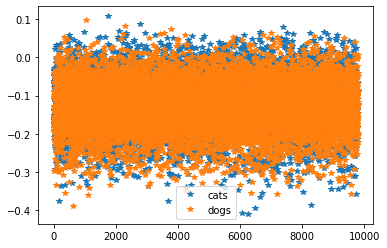

In [8]:
plot(net1(train_data[train_label==0]).view(-1).detach().numpy(),'*',label='cats')
plot(net1(train_data[train_label==1]).view(-1).detach().numpy(),'*',label='dogs')
legend()

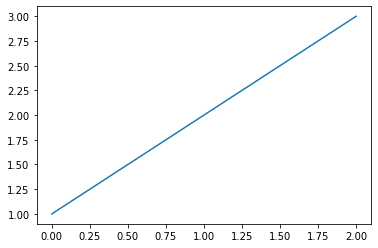

In [9]:
plot([1,2,3])

In [10]:
#create a network takes input of arbitrary number of hidden layers
class Network2(torch.nn.Module):
    def __init__(self, *n_hidden):
        super().__init__()
        layer=[]
        in_size = input_size
        for h in n_hidden:
            layer.append(torch.nn.Linear(in_size, h))
            in_size = h
            layer.append(torch.nn.ReLU())
        layer.append(torch.nn.Linear(h, 1))
        #sequential to build network
        self.network = torch.nn.Sequential(*layer)
        #classification layer to produce one single output
        #in_size is already updated while iterating through n_hidden
    def forward(self,x):
        return self.network(x.view(x.size(0),-1)).view(-1)

In [11]:
%load_ext tensorboard
import tempfile
log_dir = tempfile.mkdtemp()
%tensorboard --logdir {log_dir} --reload_interval 1

## High level overlook

#initialize variables/ hyperparameters<br>
n_epochs <br>
batch_size <br>
#create logger  <br>
training_logger = <br>
validation_logger=<br>

#create network

#create optimizer

#create loss function

#start training
for epoch in range(n_epochs):
    #shuffle training data
    
    #iterate over training data
    for iteration in range():
        #construct batch
        
        #compute forward
        
        #compute loss
        
        #logging
        
        #computer gradient with back propagation
        
        #step
    
    # log training accuracy
    
    #evaluate on validation set
    
    #log validation accuracy

In [12]:
## High level overlook

#initialize variables/ hyperparameters
n_epochs = 100
batch_size  = 128
#create logger  
import torch.utils.tensorboard as tb
train_logger =  tb.SummaryWriter(log_dir+'/model1/train')
valid_logger= tb.SummaryWriter(log_dir+'/model1/valid')

#create network
net = Network2(100,50,50).to(device)

#create optimizer
optimizer = torch.optim.SGD(net.parameters(),lr = 0.01, momentum = 0.9, weight_decay = 1e-4)

#create loss function
loss = torch.nn.BCEWithLogitsLoss()

#start training
global_step = 0
for epoch in range(n_epochs):
    #shuffle training data
    #create a permutation of indicies of our images, and use the indicies to create batch
    #this method is fast for small datasets
    permutation = torch.randperm(train_data.size(0))
    acc = []
    #iterate over training data
    #make sure we always have a full batch
    for iteration in range(0, len(permutation)-batch_size+1, batch_size):
        #construct batch
        batch_samples = permutation[iteration:iteration+batch_size]
        batch_data = train_data[batch_samples]
        batch_label = train_label[batch_samples]
        #compute forward
        o = net(batch_data)
        
        #compute loss
        #convert label with 0,1 value to floating point, error otherwise
        l = loss(o, batch_label.float())
        
        #compute accuracy:
        #(o>0).long() == batch_label =1 for each accurate sample
        #acc.extend: extend along the same dimenion
        #we will average over acc (all iteration*batch_size) later
        acc.extend(((o>0).long() == batch_label).detach().cpu().numpy())
        
        #logging
        train_logger.add_scalar('loss',float(l), global_step = global_step)
        
        #computer gradient with back propagation
        optimizer.zero_grad() #ensure we don't accumulate gradient
        l.backward()
        
        #step
        optimizer.step()
        
        global_step += 1
    
    # log training accuracy
    train_logger.add_scalar('accuracy', np.mean(acc), global_step=global_step)
    
    #evaluate on validation set
    #if validation set is large, go through subsets instead of everything
    valid_pred = net(valid_data) >0
    valid_acc = float((valid_pred.long()==valid_label).float().mean())
    
    #log validation accuracy
    valid_logger.add_scalar('accuracy', np.mean(valid_acc), global_step=global_step)

KeyboardInterrupt: 